## Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import tensorflow as tf
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
!pip install --upgrade tensorflow

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [5]:
file_path = '/content/drive/MyDrive/Dicoding/mobile_legends_reviews.csv'
df = pd.read_csv(file_path)

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15000 non-null  object
 1   userName              15000 non-null  object
 2   userImage             15000 non-null  object
 3   content               15000 non-null  object
 4   score                 15000 non-null  int64 
 5   thumbsUpCount         15000 non-null  int64 
 6   reviewCreatedVersion  14278 non-null  object
 7   at                    15000 non-null  object
 8   replyContent          125 non-null    object
 9   repliedAt             125 non-null    object
 10  appVersion            14278 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB
None


In [7]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,784cd375-85cf-40dc-abc3-f2927947792e,Yuqing Jiang,https://play-lh.googleusercontent.com/a/ACg8oc...,"I always get the mvp from the lose side, no ma...",1,14,1.9.16.9839,2024-12-21 08:54:59,NaN,NaN,1.9.16.9839
1,57de8a7a-0542-484b-b0e6-acb581e798c4,Devin Baker,https://play-lh.googleusercontent.com/a/ACg8oc...,"DO NOT DOWNLOAD, this game is a perfect exampl...",1,1295,1.9.8.9833,2024-08-21 20:18:43,NaN,NaN,1.9.8.9833
2,7787d2f1-7577-428f-87f3-96e6308fb25f,Sarah C,https://play-lh.googleusercontent.com/a-/ALV-U...,I have been playing this game for years and en...,1,3434,1.9.8.9833,2024-08-23 06:52:47,NaN,NaN,1.9.8.9833
3,0c37b7bd-1897-4891-a807-c6bb4f6f062d,Dancer Baker,https://play-lh.googleusercontent.com/a/ACg8oc...,"Love the game, but it's basically impossible t...",1,2357,1.9.16.9839,2024-09-16 10:34:52,NaN,NaN,1.9.16.9839
4,27bbf8b9-8759-4fb9-bead-e7aa44d94d5a,Andy Cortes,https://play-lh.googleusercontent.com/a-/ALV-U...,When it comes to the matchmaking portion of ra...,1,563,1.9.8.9833,2024-08-22 09:20:32,NaN,NaN,1.9.8.9833


## Data Preprocessing

In [8]:
df = df[['content', 'score']]

In [9]:
df.head()

,content,score
0,"I always get the mvp from the lose side, no ma...",1
1,"DO NOT DOWNLOAD, this game is a perfect exampl...",1
2,I have been playing this game for years and en...,1
3,"Love the game, but it's basically impossible t...",1
4,When it comes to the matchmaking portion of ra...,1


In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def to_lowercase(text):
    return text.lower()

def clean_text(text):
    text = re.sub(r"https\S+", "", text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

def lemma_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(lemmatized_words)

def preprocess_text(text):
    text = to_lowercase(text)
    text = clean_text(text)
    text = lemma_text(text)
    return text

df['content'] = df['content'].apply(preprocess_text)

In [11]:
df['label'] = df['score'].apply(lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative')


In [12]:
df.head()

,content,score,label
0,always get mvp lose side matter status skill b...,1,negative
1,download game perfect example broke dont fix p...,1,negative
2,playing game year enjoyed play game pas time h...,1,negative
3,love game basically impossible retrieve accoun...,1,negative
4,come matchmaking portion rank modeit disgustin...,1,negative


## Label Distribution

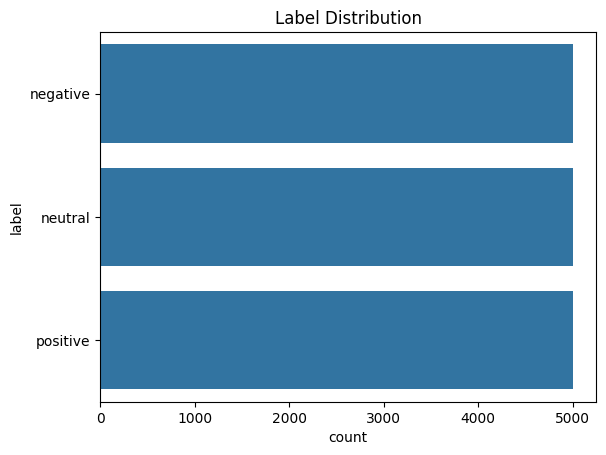

In [13]:
sns.countplot(df['label'])
plt.title('Label Distribution')
plt.show()

## Tokenization & Pad Sequences

In [14]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['content'])
X = tokenizer.texts_to_sequences(df['content'])
X = pad_sequences(X, maxlen=max_len, padding='post')

In [15]:
print(tokenizer.word_index)

{'game': 1, 'player': 2, 'play': 3, 'get': 4, 'match': 5, 'like': 6, 'good': 7, 'matchmaking': 8, 'hero': 9, 'system': 10, 'time': 11, 'team': 12, 'really': 13, 'playing': 14, 'fix': 15, 'even': 16, 'fun': 17, 'im': 18, 'rank': 19, 'one': 20, 'dont': 21, 'teammate': 22, 'issue': 23, 'star': 24, 'problem': 25, 'make': 26, 'still': 27, 'also': 28, 'always': 29, 'great': 30, 'please': 31, 'love': 32, 'ive': 33, 'new': 34, 'character': 35, 'keep': 36, 'thing': 37, 'skin': 38, 'would': 39, 'bad': 40, 'year': 41, 'lot': 42, 'cant': 43, 'lose': 44, 'much': 45, 'update': 46, 'people': 47, 'lag': 48, 'skill': 49, 'many': 50, 'mobile': 51, 'legend': 52, 'mode': 53, 'give': 54, 'sometimes': 55, 'gameplay': 56, 'back': 57, 'making': 58, 'experience': 59, 'every': 60, 'moonton': 61, 'ranked': 62, 'need': 63, 'there': 64, 'doesnt': 65, 'enemy': 66, 'phone': 67, 'played': 68, 'since': 69, 'way': 70, 'want': 71, 'win': 72, 'better': 73, 'u': 74, 'getting': 75, 'solo': 76, 'know': 77, 'graphic': 78, 'h

In [131]:
tokenized_data = {
    'Original Text': df['content'].head(5),  # Contoh 5 teks asli
    'Tokenized Text': [tokenizer.texts_to_sequences([text])[0] for text in df['content'].head(5)],  # Tokenisasi
    'Padded Text': [list(X[i]) for i in range(5)]  # Tokenisasi dengan padding
}

tokenized_df = pd.DataFrame(tokenized_data)

print("Tokenized and Padded Text:")
display(tokenized_df)

Tokenized and Padded Text:


,Original Text,Tokenized Text,Padded Text
0,always get mvp lose side matter status skill b...,"[29, 4, 502, 44, 728, 426, 1022, 49, 73, 348, ...","[29, 4, 502, 44, 728, 426, 1022, 49, 73, 348, ..."
1,download game perfect example broke dont fix p...,"[223, 1, 372, 510, 845, 21, 15, 68, 1, 41, 184...","[223, 1, 372, 510, 845, 21, 15, 68, 1, 41, 184..."
2,playing game year enjoyed play game pas time h...,"[14, 1, 41, 648, 3, 1, 429, 11, 129, 362, 1, 8...","[14, 1, 41, 648, 3, 1, 429, 11, 129, 362, 1, 8..."
3,love game basically impossible retrieve accoun...,"[32, 1, 638, 428, 740, 128, 4, 469, 299, 345, ...","[32, 1, 638, 428, 740, 128, 4, 469, 299, 345, ..."
4,come matchmaking portion rank modeit disgustin...,"[144, 8, 1891, 19, 1892, 1026, 107, 244, 52, 1...","[144, 8, 1891, 19, 1892, 1026, 107, 244, 52, 1..."


## Label Encoding

In [16]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])
y = to_categorical(y)

In [132]:
encoded_data = {
    'Original Label': df['label'].head(5),  # Contoh 5 label asli
    'Encoded Label (Number)': [label_encoder.transform([label])[0] for label in df['label'].head(5)],  # Label encoded
    'One-Hot Encoded Label': [list(y[i]) for i in range(5)]  # Label one-hot encoded
}

encoded_df = pd.DataFrame(encoded_data)

print("\nLabel Encoding:")
display(encoded_df)


Label Encoding:


,Original Label,Encoded Label (Number),One-Hot Encoded Label
0,negative,0,"[1.0, 0.0, 0.0]"
1,negative,0,"[1.0, 0.0, 0.0]"
2,negative,0,"[1.0, 0.0, 0.0]"
3,negative,0,"[1.0, 0.0, 0.0]"
4,negative,0,"[1.0, 0.0, 0.0]"


## Split Dataset

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
X.shape

(15000, 100)

In [19]:
y.shape

(15000, 3)

## Model Training

### Callbacks

In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Scheme 1: LSTM

#### LSTM Model Setup

In [21]:
model_1 = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [22]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model_1.build(input_shape=(None, max_len))
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,420,035 (5.42 MB)

 Trainable params: 1,420,035 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

#### LSTM Model Training

In [24]:
history_1 = model_1.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 216ms/step - accuracy: 0.3365 - loss: 1.1018 - val_accuracy: 0.3254 - val_loss: 1.0996
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 85s 225ms/step - accuracy: 0.3352 - loss: 1.0993 - val_accuracy: 0.3417 - val_loss: 1.0985
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.3354 - loss: 1.0987 - val_accuracy: 0.3417 - val_loss: 1.0980
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 214ms/step - accuracy: 0.3431 - loss: 1.0979 - val_accuracy: 0.3417 - val_loss: 1.0984
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.3228 - loss: 1.0983 - val_accuracy: 0.3267 - val_loss: 1.0968
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 84s 221ms/step - accuracy: 0.4132 - loss: 1.0718 - val_accuracy: 0.3613 - val_loss: 1.0928
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 221ms/step - accuracy: 0.4601 - loss: 1.0090 - val_accuracy: 0.8717 - val_loss: 0.4076
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 217ms/step - accuracy: 0.8652 -

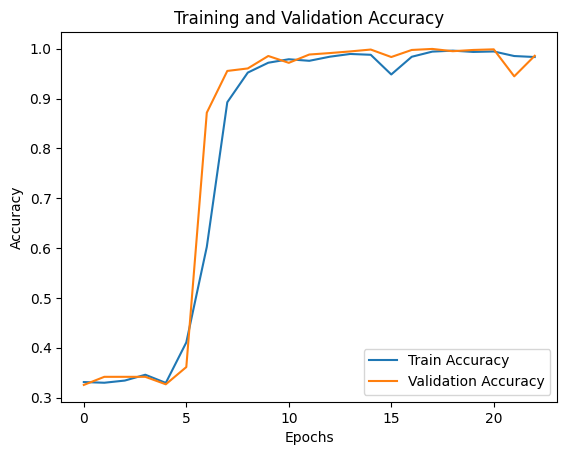

In [25]:
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

#### LSTM Model Evaluation

In [26]:
y_pred_1 = model_1.predict(X_test).argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)
print("LSTM Accuracy:", accuracy_score(y_test_classes, y_pred_1))
print(classification_report(y_test_classes, y_pred_1))

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step
LSTM Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1037
           1       1.00      1.00      1.00       970
           2       1.00      1.00      1.00       993

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



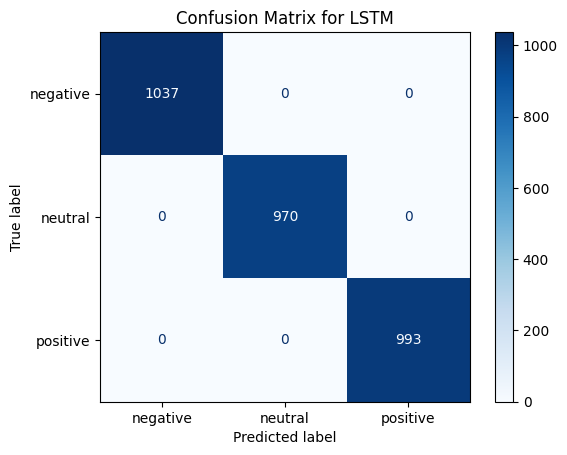

In [27]:
cm = confusion_matrix(y_test_classes, y_pred_1)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix for LSTM')
plt.show()

#### LSTM Model Inference

In [117]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_1.predict(padded_seq).argmax(axis=1)
    return label_encoder.inverse_transform(pred)

print(predict_sentiment("Fix your matchmaking, always crossing servers. it's just very unfair because the game is so lag when the opponent is from another server, it's a pity that the player's effort in ranking can be defeated just because that server is crossed."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
['negative']


In [122]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_1.predict(padded_seq).argmax(axis=1)
    return label_encoder.inverse_transform(pred)

print(predict_sentiment("This is a good game. But the connectivity is so bad, always have a high ping.. if i lose because of skill is ok, but lose because connectivity is so annoying.."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
['neutral']


In [119]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_1.predict(padded_seq).argmax(axis=1)
    return label_encoder.inverse_transform(pred)

print(predict_sentiment("It is nice app I have seen,grapics here in this game is vey good.Heroes,skins and all the battlefields are really marvellous and super."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
['positive']


### Scheme 2: Bi-LSTM

#### Bi-LSTM Model Setup

In [28]:
model_2 = Sequential([
    Embedding(input_dim=max_words, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [29]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
model_2.build(input_shape=(None, max_len))
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,559,811 (5.95 MB)

 Trainable params: 1,559,811 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

#### Bi-LSTM Model Training

In [31]:
history_2 = model_2.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 130s 411ms/step - accuracy: 0.6257 - loss: 0.7400 - val_accuracy: 0.9942 - val_loss: 0.0150
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 449ms/step - accuracy: 0.9982 - loss: 0.0108 - val_accuracy: 0.9987 - val_loss: 0.0095
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 133s 418ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.9987 - val_loss: 0.0060
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 422ms/step - accuracy: 1.0000 - loss: 5.5805e-04 - val_accuracy: 0.9987 - val_loss: 0.0028
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 126s 422ms/step - accuracy: 0.9999 - loss: 2.4489e-04 - val_accuracy: 0.9967 - val_loss: 0.0282
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 139s 412ms/step - accuracy: 0.9908 - loss: 0.0376 - val_accuracy: 0.9987 - val_loss: 0.0079
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 142s 412ms/step - accuracy: 1.0000 - loss: 3.5368e-04 - val_accuracy: 0.9987 - val_loss: 0.0086
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 142s 414ms/step 

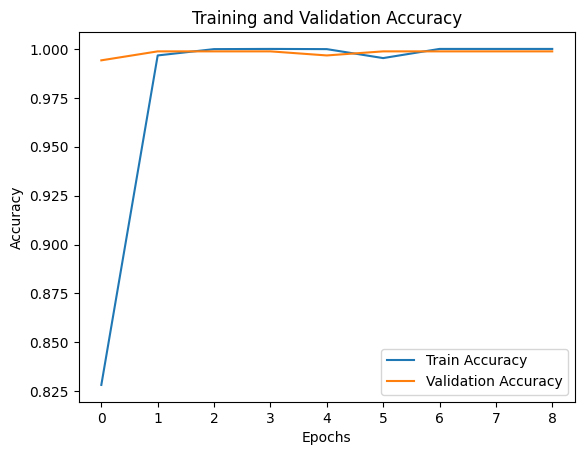

In [32]:
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

#### Bi-LSTM Model Evaluation

In [33]:
y_pred_2 = model_2.predict(X_test).argmax(axis=1)
print("Bi-LSTM Accuracy:", accuracy_score(y_test_classes, y_pred_2))
print(classification_report(y_test_classes, y_pred_2))

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step
Bi-LSTM Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1037
           1       1.00      1.00      1.00       970
           2       1.00      1.00      1.00       993

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



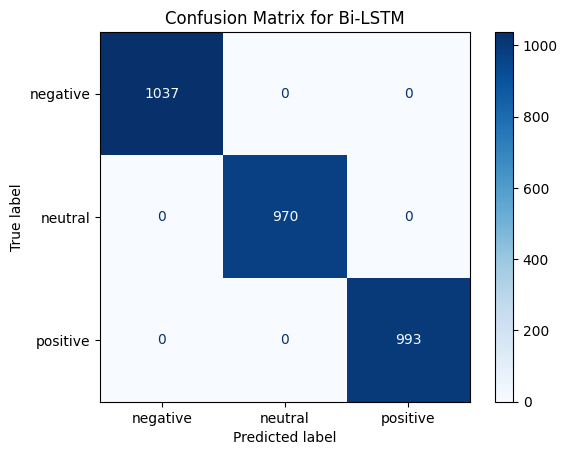

In [34]:
cm = confusion_matrix(y_test_classes, y_pred_2)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix for Bi-LSTM')
plt.show()

#### Bi-LSTM Model Inference

In [108]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_2.predict(padded_seq).argmax(axis=1)
    return label_encoder.inverse_transform(pred)

print(predict_sentiment("Fix your matchmaking, always crossing servers. it's just very unfair because the game is so lag when the opponent is from another server, it's a pity that the player's effort in ranking can be defeated just because that server is crossed."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
['negative']


In [109]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_2.predict(padded_seq).argmax(axis=1)
    return label_encoder.inverse_transform(pred)

print(predict_sentiment("Not good enough. Poor matchmaking, server lag and bugs. Please improve it as much as good or better just dont paying attention for income or other stuff but give more attention for the player's convenient."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
['neutral']


In [125]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_2.predict(padded_seq).argmax(axis=1)
    return label_encoder.inverse_transform(pred)

print(predict_sentiment("Love the game. But when i try out a new hero and don't play as well as i usually do, i get reported for not taking the game seriously, which is very unfair.  "))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
['positive']


### Scheme 3: Bi-GRU

#### Bi-GRU Model Setup

In [56]:
model_3 = Sequential([
    Embedding(input_dim=max_words, output_dim=128),
    Bidirectional(GRU(128, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

In [57]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [58]:
model_3.build(input_shape=(None, max_len))
model_3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,494,787 (5.70 MB)

 Trainable params: 1,494,787 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

#### Bi-GRU Model Training

In [59]:
history_3 = model_3.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 106s 334ms/step - accuracy: 0.6983 - loss: 0.5973 - val_accuracy: 0.9987 - val_loss: 0.0066
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 139s 325ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.9987 - val_loss: 0.0097
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 110s 365ms/step - accuracy: 1.0000 - loss: 2.1966e-04 - val_accuracy: 0.9987 - val_loss: 0.0092
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 341ms/step - accuracy: 1.0000 - loss: 2.9586e-05 - val_accuracy: 0.9992 - val_loss: 0.0089
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 109s 365ms/step - accuracy: 1.0000 - loss: 2.6897e-05 - val_accuracy: 0.9992 - val_loss: 0.0091


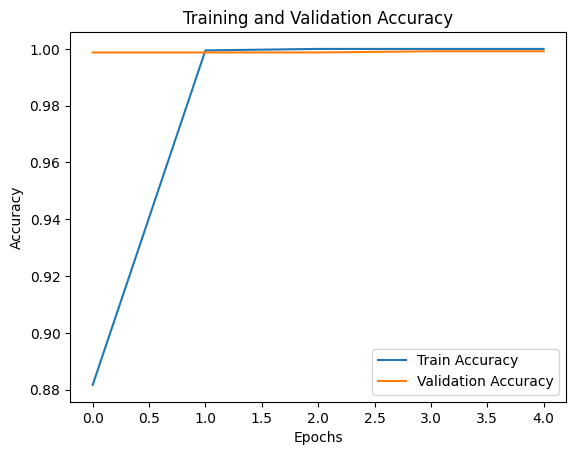

In [60]:
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

#### Bi-GRU Model Evaluation

In [63]:
y_pred_3 = model_3.predict(X_test).argmax(axis=1)
print("Bi-GRU Accuracy:", accuracy_score(y_test_classes, y_pred_3))
print(classification_report(y_test_classes, y_pred_3))

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
Bi-GRU Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1037
           1       1.00      1.00      1.00       970
           2       1.00      1.00      1.00       993

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



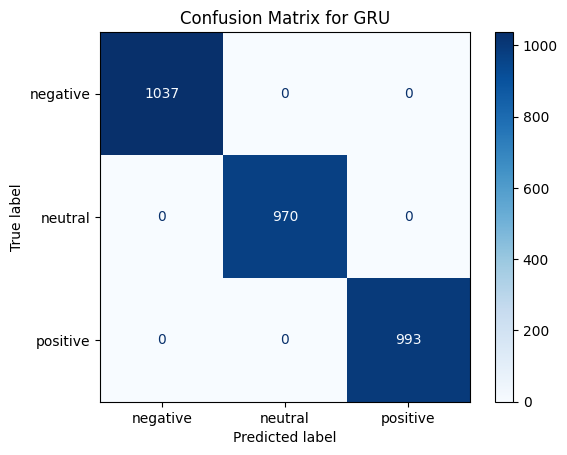

In [64]:
cm = confusion_matrix(y_test_classes, y_pred_3)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix for GRU')
plt.show()

#### Bi-GRU Model Inference

In [111]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_3.predict(padded_seq).argmax(axis=1)
    return label_encoder.inverse_transform(pred)

print(predict_sentiment("Fix your matchmaking, always crossing servers. it's just very unfair because the game is so lag when the opponent is from another server, it's a pity that the player's effort in ranking can be defeated just because that server is crossed."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
['negative']


In [112]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_3.predict(padded_seq).argmax(axis=1)
    return label_encoder.inverse_transform(pred)

print(predict_sentiment("Not good enough. Poor matchmaking, server lag and bugs. Please improve it as much as good or better just dont paying attention for income or other stuff but give more attention for the player's convenient."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
['neutral']


In [123]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_3.predict(padded_seq).argmax(axis=1)
    return label_encoder.inverse_transform(pred)

print(predict_sentiment("Fun and all but most characters are extremely overpriced for how little currency you get from matches and most characters are also extremely unbalanced, but if you look past that the games pretty fun."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
['positive']


## Requirements

In [129]:
pip freeze > requirements.txt